In [1]:
# !pip install optuna
# !pip install imblearn

# Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-общая-информация" data-toc-modified-id="Загрузка-данных-и-общая-информация-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных и общая информация</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-выборок" data-toc-modified-id="Подготовка-выборок-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подготовка выборок</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Важность-основных-факторов" data-toc-modified-id="Важность-основных-факторов-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Важность основных факторов</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

**Заказчик исследования:** компания «Чётенькое такси».  
**Цель исследования:** построить модель прогнозирования количества заказов такси в аэропортах на следующий час.

**Особенности проекта:** Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Исходные данные:**  
Исходные данные представлены в датасете taxi.csv:  

В датасете содержатся следующие признаки:  
- datetime (дата и время);  
- num_orders (количество заказов).

**Превью:** в проекте рассмотрены модели LinearRegression, DecisionTreeRegressor, RandomForestRegressor, CatBoostRegressor.

**Используемые библиотеки:**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import optuna
import timeit
import statsmodels.api as sm

from catboost import CatBoostRegressor
from imblearn.pipeline import Pipeline, make_pipeline
from optuna.distributions import FloatDistribution as floatd
from optuna.distributions import IntDistribution as intd
from optuna.integration import OptunaSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

**Используемые константы:**

In [3]:
ALPHA = 0.05                                          # уровень значимости (для проверки гипотезы о стационарности врем. ряда)
MAX_LAG = 72                                          # количество отстающих значений (до трех суток)
ROLLING_MEAN_SIZE = 15                                # размер окна
STEP = 1                                              # шаг периода прогнозирования
RS = 42                                               # значение random_state
# RS = np.random.RandomState(5)

## Загрузка данных и общая информация
<a id="section_1"></a>

Загружаем датасет:

In [4]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
def inf(df):
    '''функция получения общей информации'''
    print('Размер датафрейма:')
    print(df.shape)
    print('_' * 50)
    print()
    print('Общая информация о датафрейме:')
    print(df.info(memory_usage='deep'))
    print('_' * 50)
    print()
    print('Несколько строк датафрейма:')
    display(df.sample(random_state=0, n=5))
    print('_' * 50)
    print()
    print('Количество полных дубликатов:')
    print(df.duplicated().sum())
    print('_' * 50)  
    try:
        if ('id' in df.columns) & ('case_id' in df.columns):
            print()
            print('Количество дубликатов без учета полей идентификаторов:')
            print(df.drop(columns=['id', 'case_id']).duplicated().sum())
            print('_' * 50)
        elif 'id' in df.columns:
            print()
            print('Количество дубликатов без учета полей идентификаторов:')
            print(df.drop(columns=['id']).duplicated().sum())
            print('_' * 50)
        elif 'case_id' in df.columns:
            print()
            print('Количество дубликатов без учета полей идентификаторов:')
            print(df.drop(columns=['case_id']).duplicated().sum())
            print('_' * 50)
    except:
        pass           
    print()
    print('Описательная статистика числовых значений:')
    display(df.describe().T)
    print('_' * 50)
    print()
    print('Количество пропусков:')
    print(df.isna().sum())
    print()
    print('Количество пропусков в процентах:')
    print(df.isna().mean()*100) 

Выводим общую информацию по исходному датафрейму:

In [6]:
inf(df)

Размер датафрейма:
(26496, 1)
__________________________________________________

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
__________________________________________________

Несколько строк датафрейма:


,num_orders
datetime,
2018-07-30 06:00:00,4
2018-08-14 13:50:00,10
2018-04-07 10:10:00,6
2018-08-04 12:30:00,10
2018-05-27 02:30:00,15


__________________________________________________

Количество полных дубликатов:
26415
__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


__________________________________________________

Количество пропусков:
num_orders    0
dtype: int64

Количество пропусков в процентах:
num_orders    0.0
dtype: float64


**Вывод**  
1. Исходный датафрейм состоит из 26496 строк и 1 столбец. В Индексе содержатся даты и время.
2. Датафрейм содержит данные за период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00.
3. Пропуски отсутствуют.
4. Минимальное количество заказов - 0, максимальное - 119, медиана - 13.

## Подготовка

Производим ресемплинг временного ряда. Период - 1 час:

In [7]:
df = df.resample('1H').sum().sort_index()

**Дополнительные признаки**

Создаем дополнительные признаки времени: месяц (month), неделя (week), день (day), день недели (dayofweek), час (hour). Признак года не включаем, так как он одинаков для всех событий.  

In [8]:
df['month'] = df.index.month                                                    # получаем из индекса месяц
df['day'] = df.index.day                                                        # получаем из индекса номер дня месяца 
df['dayofweek'] = df.index.dayofweek                                            # получаем из индекса номер дня недели 
df['hour'] = df.index.hour                                                      # получаем из индекса час

Помимо признаков времени добавляем признаки отстающих значений по количеству вызовов:

In [9]:
for lag in range(1, MAX_LAG + 1):                                       # циклом получаем количество отстающих значений
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)              # создаем признак по количеству отстающих значений

Создаем признак скользящего среднего количества вызовов (rolling_mean), смещенного на один временной интервал:

In [10]:
df['rolling_mean'] = df['num_orders'].shift(periods=STEP).rolling(ROLLING_MEAN_SIZE).mean()

**Вывод:**  
1. Произведен ресемплинг временного ряда. Период - 1 час.
2. Добавлены дополнительные признаки:
 - month (месяц события);
 - day (день месяца события);
 - dayofweek (день недели события);
 - hour (час события);
 - признаки количества заказов по отстающим значениям;
 - rolling_mean (скользящего среднего количества вызовов).

## Анализ

Разложим временной период на тренд, сезонность и остаток декомпозиции. В качестве временных периодов для визуализации выбираем один день и один час.

Производим ресемплинг временного ряда. Период - 1 день:

In [11]:
df_day_period = df.resample('1D').sum()

Декомпанизуем временной ряд:

In [12]:
decomposed_day_period = seasonal_decompose(df_day_period['num_orders'])              # декомпозиция с периодом 1 день
decomposed = seasonal_decompose(df['num_orders'])                                    # декомпозиция с периодом 1 час

**Тренд**

Тренд строим по данным с периодом в один день: период в час слишком мал, на графике возникает много шумов.

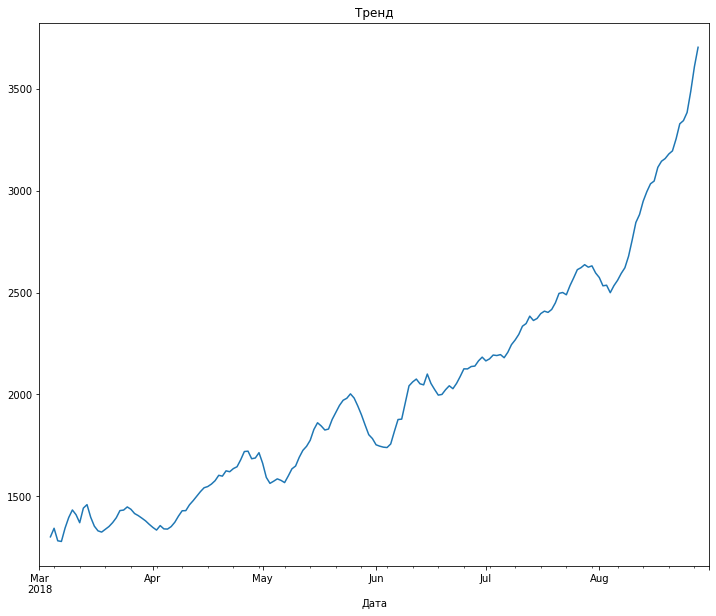

In [13]:
plt.figure(figsize=(12,10))
decomposed_day_period.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.show()

**Сезонность**

Определяем сезонность на данных с периодом в один день:

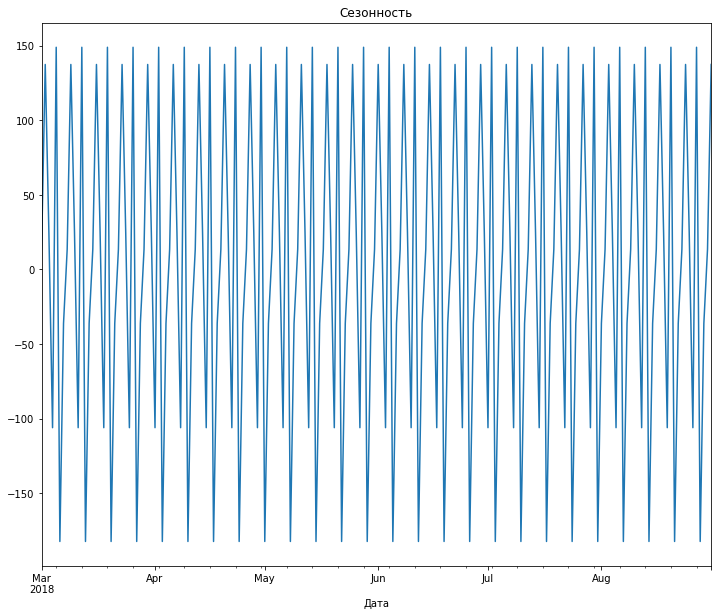

In [14]:
plt.figure(figsize=(12,10))
decomposed_day_period.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.show()

Определяем сезонность на данных с периодом в один час. График сезонности за весь период малоинформативен. Рассмотрим сезонность на меньшем масштабе - неделя:

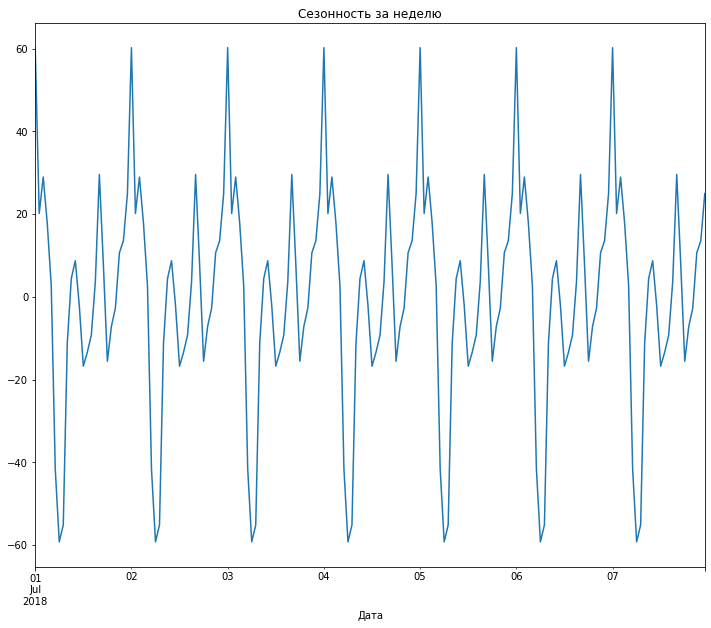

In [15]:
plt.figure(figsize=(12,10))
decomposed.seasonal['2018-07-01':'2018-07-07'].plot(ax=plt.gca())
plt.title('Сезонность за неделю')
plt.xlabel('Дата')
plt.show()

В данных присутствует недельная и дневная сезонности.

**Остаток декомпозиции**

График остатка декомпозиции на данных с периодом в 1 день:

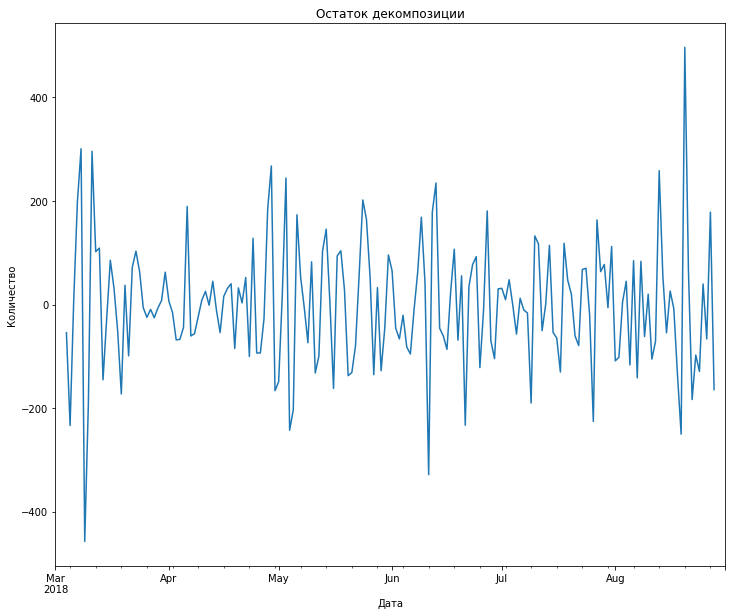

In [16]:
plt.figure(figsize=(12,10))
decomposed_day_period.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

**Гипотеза о стационарности временного ряда**

Формулируем гипотезы H0 и H1:
- Гипотеза H0: временной ряд стационарен
- Гипотеза H1: временной ряд не стационарен.

Получаем результаты теста Дики-Фуллера по временному ряду:

In [17]:
result = adfuller(df['num_orders'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -3.0689242890279558
p-value: 0.028940051402612906
Critical Values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}


In [18]:
if result[1] < ALPHA:
    print('Значение p-value ниже уровеня значимости ({}) - с высокой долей вероятности временной ряд - стационарный.'.format(ALPHA))
else:
    print('Значение p-value выше уровеня значимости ({}) - с высокой долей вероятности временной ряд - не стационарный.'.format(ALPHA))

Значение p-value ниже уровеня значимости (0.05) - с высокой долей вероятности временной ряд - стационарный.


**Вывод:**  
1. В данных присутствует недельная и дневная сезонности.
2. Значение p-value (0.029) ниже уровеня значимости (0.05) - с высокой долей вероятности временной ряд - стационарный.

## Обучение

### Подготовка выборок

**Разделение выборок**

Разделяем выборку на тестовую и обучающую в отношении 1:9.

In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

Выделяем целевой признак:

In [20]:
def separation(df):
    '''Функция разделения датафреймов на признаки и целевой признак'''
    X = df.drop(['num_orders'], axis=1)
    y = df['num_orders']
    return X, y

In [21]:
X_train, y_train = separation(train)
X_test, y_test = separation(test)

Проверяем размеры выборок:

In [22]:
print('Колмчество наблюдений в обучающей выборке - {}.'.format(X_train.shape[0]))
print('Колмчество наблюдений в тестовой выборке - {}.'.format(X_test.shape[0]))
print('Колмчество признаков в обучающей и тестовой выборках - {}.'.format(X_test.shape[1]))

Колмчество наблюдений в обучающей выборке - 3902.
Колмчество наблюдений в тестовой выборке - 442.
Колмчество признаков в обучающей и тестовой выборках - 77.


**Преобразование выборок**

Для модели LinearRegression произведем масштабирование числовых признаков и кодирование (OHE) категориальных. Обработанные признаки для этой модели будут содержаться в датафреймах X_train_scaler_ohe и X_test_scaler_ohe.  
Для моделей DecisionTreeRegressor, RandomForestRegressor масштабирование числовых признаков. Обработанные признаки для этих моделей будут содержаться в датафреймах X_train_scaler и X_test_scaler соответственно.  
Для модели CatBoostRegressor будем использовать необработанные выборки X_train и X_test, так как у этой модели кодирование и масштабирование производится автоматически в процессе обучения.

Разделяем признаки на количественные и категориальные:

In [23]:
categorical_features = ['month', 'month', 'day', 'dayofweek', 'hour']           # категориальные признаки
numerical_features = ['rolling_mean']                                           # количественные признаки

Классы масштабирования и кодирования признаков:

In [24]:
class ScalerTransformation(BaseEstimator, TransformerMixin):
    '''класс обучения и трансформации для масштабирования количественных признаков'''
    scaler = StandardScaler()                                      
    
    def fit(self, X, y=None):
        X = X.copy()                                               # делаем копию матрицы признаков
        self.scaler.fit(X[numerical_features])                     # обучаем scaler на числовых данных обучающей выборки
        return self
    
    def transform(self, X, y=None):
        X = X.copy()                                                           # делаем копию матрицы признаков
        X[numerical_features] = self.scaler.transform(X[numerical_features])   # масштабируем числовые значения
        return X

In [25]:
class OheEncoder(BaseEstimator, TransformerMixin): 
    '''класс обучения и трансформации для кодирования категориальных признаков'''
    
    encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
    
    def fit(self, X, y=None):
        X = X.copy()                                      # делаем копию матрицы признаков
        self.encoder.fit(X[categorical_features])         # обучаем encoder на категориальных данных обучающей выборки
        return self
    
    def transform(self, X):
        X = X.copy()                                                         # делаем копию матрицы признаков
        X = X.reset_index()                                                  # сбрасываем индексы и создаем признак datetime
        feature_arr = self.encoder.transform(X[categorical_features]).toarray()      # кодируем категориальные значения
        ohe_labels = self.encoder.get_feature_names_out(categorical_features)        # создаем список названий новых признаков
        features = pd.DataFrame(                                             # собираем результаты в датафрейм
               feature_arr,
               columns=ohe_labels)
        X = X.join(features)                                                 # добавляем результаты кодирования в исходную таблицу
        X = X.drop(categorical_features, axis=1)                             # удаляем исходные категориальные столбцы
        X.columns = map(str.lower, X.columns)                                # переводим названия столбцов в нижний регистр
        X.index = X['datetime']                                              # назначаем индексам значения признака datetime
        X = X.drop(['datetime'], axis=1)                                     # удаляем признак datetime
        return X

Создаем и обучаем пайплайн кодирования и масштабирования значений признаков для модели LinearRegression:

In [26]:
pipe_scaler_ohe = make_pipeline(ScalerTransformation(), OheEncoder())
pipe_scaler_ohe.fit(X_train)

Pipeline(steps=[('scalertransformation', ScalerTransformation()),
                ('oheencoder', OheEncoder())])

Трансформируем признаки тестовой и обучающих выборок для модели LinearRegression:

In [27]:
X_train_scaler_ohe = pipe_scaler_ohe.transform(X_train)
X_test_scaler_ohe = pipe_scaler_ohe.transform(X_test)

Определяем количество признаков после кодирования:

In [28]:
print('Колмчество признаков после кодирования (OHE) в обучающей и тестовой выборках - {}.'.format(X_train_scaler_ohe.shape[1]))

Колмчество признаков после кодирования (OHE) в обучающей и тестовой выборках - 142.


Создаем и обучаем пайплайн кодирования и масштабирования значений признаков для моделей DecisionTreeRegressor, RandomForestRegressor:

In [29]:
pipe_scaler = make_pipeline(ScalerTransformation())
pipe_scaler.fit(X_train)

Pipeline(steps=[('scalertransformation', ScalerTransformation())])

Трансформируем признаки тестовой и обучающих выборок для модели DecisionTreeRegressor, RandomForestRegressor:

In [30]:
X_train_scaler = pipe_scaler.transform(X_train)
X_test_scaler = pipe_scaler.transform(X_test)

###  Обучение моделей

Инициализируем TimeSeriesSplit для кросс валидации временных рядов:

In [31]:
tscv = TimeSeriesSplit(n_splits=5)

**Функции**

In [32]:
def optuna_search(model, params, X_train = X_train_scaler):
    '''Функция обучения модели'''
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)                         # отключение логгирования
    model = OptunaSearchCV(model, params, scoring = 'neg_mean_squared_error', cv=tscv, random_state=RS)                               # передача данных в OptunaSearchCV
    start_time = timeit.default_timer()                                          # начальное время обучения
    model.fit(X_train, y_train)                                                  # обучение модели
    time_fit = timeit.default_timer() - start_time                               # длительность обучения
    y_pred = model.best_estimator_.predict(X_train)                              # предсказание
    rmse = np.sqrt(abs(model.score(X_train, y_train))).round(3)                          # метрика RMSE
    print('RMSE: {}'.format(rmse))

    return model, rmse, time_fit

**LinearRegression**

Передаем LinearRegression в функцию обучения модели без подбираемых гиперпараметров: для того только, чтобы получить RMSE на кросс валидации.

In [33]:
params_lr = {}                                                           # словарь подбираемых гиперпараметров
model_lr = LinearRegression()                                            # инициализация модели
# вызов функции обучения модели
best_model_lr, rmse_lr, time_fit_lr = optuna_search(model_lr, params_lr, X_train_scaler_ohe)

/tmp/ipykernel_516/1577475257.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model = OptunaSearchCV(model, params, scoring = 'neg_mean_squared_error', cv=tscv, random_state=RS)                               # передача данных в OptunaSearchCV


RMSE: 21.544


**DecisionTreeRegressor**

In [34]:
params_dtc = {'min_samples_leaf' : intd(1, 10, False, 3),                 # словарь подбираемых гиперпараметров
              'min_samples_split' : intd(2, 10, False, 3),
              'max_depth' : intd(1, 10, False, 3)}    
model_dtc = DecisionTreeRegressor(random_state=RS)                        # инициализация модели
# вызов функции обучения модели
best_model_dtc, rmse_dtc, time_fit_dtc = optuna_search(model_dtc, params_dtc)

/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [2, 10] and step=3, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(
/tmp/ipykernel_516/1577475257.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model = OptunaSearchCV(model, params, scoring = 'neg_mean_squared_error', cv=tscv, random_state=RS)                               # передача данных в OptunaSearchCV


RMSE: 25.069


**RandomForestRegressor**

In [35]:
params_rfc = {'min_samples_leaf' : intd(1, 10, False, 3),                  # словарь подбираемых гиперпараметров
              'min_samples_split' : intd(2, 10, False, 3),
              'max_depth' : intd(1, 10, False, 3),
              'n_estimators' : intd(100, 150, False, 10)
             }
model_rfc = RandomForestRegressor(random_state=RS)                         # инициализация модели
# вызов функции обучения модели
best_model_rfc, rmse_rfc, time_fit_rfc = optuna_search(model_rfc, params_rfc)

/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [2, 10] and step=3, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(
/tmp/ipykernel_516/1577475257.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model = OptunaSearchCV(model, params, scoring = 'neg_mean_squared_error', cv=tscv, random_state=RS)                               # передача данных в OptunaSearchCV


RMSE: 14.161


**CatBoostRegressor**

In [36]:
params_cb = {'learning_rate' : floatd(0.01, 0.91, False, 0.9),             # словарь подбираемых гиперпараметров
             'l2_leaf_reg': intd(2, 4, False, 2)
            }
model_cb = CatBoostRegressor(verbose=False,                                # инициализация модели
                            cat_features = categorical_features
                            )
# вызов функции обучения модели
best_model_cb, rmse_cb, time_fit_cb = optuna_search(model_cb, params_cb, X_train)

/tmp/ipykernel_516/1577475257.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model = OptunaSearchCV(model, params, scoring = 'neg_mean_squared_error', cv=tscv, random_state=RS)                               # передача данных в OptunaSearchCV


RMSE: 18.012


Создаем сводную таблицу результатов:

In [37]:
df_model = pd.DataFrame({'model' : ['LinearRegression', 'DecisionRegressor', 'RandomForestRegressor', 'CatBoostRegressor'],
                         'rmse_train' : [rmse_lr, rmse_dtc, rmse_rfc, rmse_cb],
                         'time_fit' : [time_fit_lr, time_fit_dtc, time_fit_rfc, time_fit_cb],
                         'best_model' : [best_model_lr, best_model_dtc, best_model_rfc, best_model_cb],
                         'x_test' : [X_test_scaler_ohe, X_test_scaler, X_test_scaler, X_test]})
df_model[['model', 'rmse_train', 'time_fit']]

,model,rmse_train,time_fit
0,LinearRegression,21.544,14.790400
1,DecisionRegressor,25.069,2.528233
2,RandomForestRegressor,14.161,171.279839
3,CatBoostRegressor,18.012,815.426827


Определяем наилучшую модель - с наименьшим значением RMSE:

In [38]:
best_model_row = df_model.loc[df_model['rmse_train'] == df_model['rmse_train'].min()].reset_index(drop=True)
best_model_row[['model', 'rmse_train', 'time_fit']]

,model,rmse_train,time_fit
0,RandomForestRegressor,14.161,171.279839


Параметры лучшей модели:

In [39]:
best_model_row.iloc[0][3].best_params_

{'min_samples_leaf': 4,
 'min_samples_split': 8,
 'max_depth': 10,
 'n_estimators': 100}

### Важность основных факторов

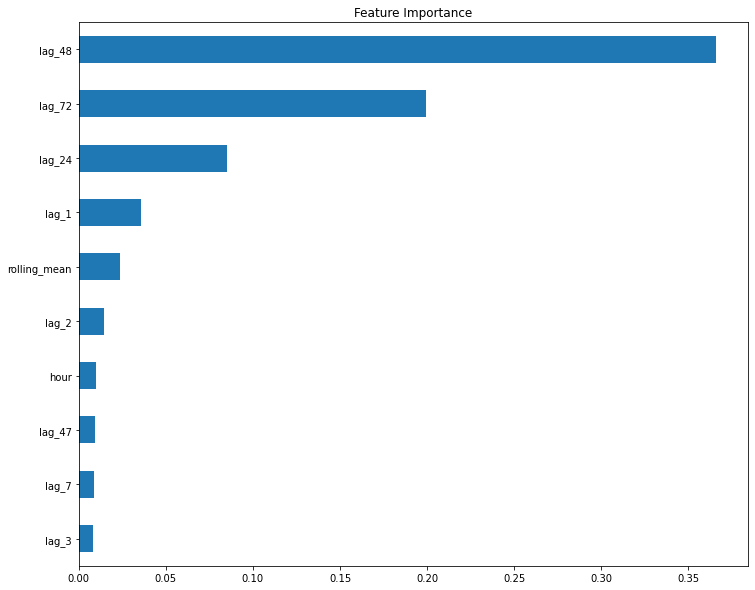

In [40]:
if best_model_row.iloc[0, 0] == 'LinearRegression':
    importance = best_model_lr.best_estimator_.coef_[0]      # получаем коэффициенты признаков для модели LogisticRegression
    X_train = X_train_scaler_ohe                             # выбираем обучающую выборку
else:
    # получаем коэффициенты признаков для других моделей
    importance = best_model_row.iloc[0, 3].best_estimator_.feature_importances_
    if (best_model_row.iloc[0, 0] == 'DecisionRegressor') | (best_model_row.iloc[0, 0] == 'RandomForestRegressor'):
        X_train = X_train_scaler                                                 # выбираем обучающую выборку
# собираем признаки в серию
importance_features = pd.Series(importance, index=X_train.columns).sort_values(ascending=True).tail(10)
plt.figure(figsize=(12,10))                                           # задаем размер окна диаграммы
importance_features.plot(kind='barh',title = 'Feature Importance')    # визуализируем диаграмму
plt.show()

Наиболее важные признаки для лучшей модели - значения, отстающее на 24, 48 и 72 часа.

**Вывод:**  
1. Произведено масштабирование числовых признаков и кодировка категориальных методом OneHotEncoder для модели LinearRegression.
2. Произведено масштабирование числовых признаков для моделей DecisionRegressor и RandomForestRegressor.
3. Обучены следующие модели:
 - LinearRegression;
 - DecisionTreeRegressor;
 - RandomForestRegressor;
 - CatBoostRegressor.
 
 
4. Наилучшая модель по метрике RMSE - RandomForestRegressor. Метрики лучшей модели на обучающей выборке:  
 - RMSE = 14.161;  
 - time_fit (время обучения) = 242.108375 сек.;
 
   Параметры лучшей модели:
 - min_samples_leaf: 4;
 - min_samples_split: 8;
 - max_depth: 10;
 - n_estimators: 100.
 
 
5. Наиболее важные признаки для лучшей модели - значения, отстающее на 24, 48 и 72 часа.

## Тестирование

Получаем лучшую модель и соответствующую тестовую выборку признаков:

In [41]:
best_model = best_model_row.iloc[0][3]                               # лучшая модель
X_test_best = best_model_row.iloc[0][4]                              # признаки тестовой выборки

Предсказываем на тестовой выборке:

In [42]:
y_pred_test = best_model.predict(X_test_best)

Рассчитываем RMSE на тестовой выборке:

In [43]:
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('RMSE на тестовой выборке: {:.3f}'.format(rmse_test))

RMSE на тестовой выборке: 40.039


## Общий вывод

**Загрузка данных и общая информация**  

1. Исходный датафрейм состоит из 26496 строк и 1 столбец. В Индексе содержатся даты и время.
2. Датафрейм содержит данные за период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00.
3. Пропуски отсутствуют.
4. Минимальное количество заказов - 0, максимальное - 119, медиана - 13. 


**Подготовка**  

1. Произведен ресемплинг временного ряда. Период - 1 час.  
2. Добавлены дополнительные признаки:  
 - month (месяц события);  
 - day (день месяца события);  
 - dayofweek (день недели события);  
 - hour (час события);  
 - признаки количества заказов по отстающим значениям;  
 - rolling_mean (скользящего среднего количества вызовов).  
 
**Анализ**  

1. В данных присутствует недельная и дневная сезонности.
2. Значение p-value (0.029) ниже уровеня значимости (0.05) - с высокой долей вероятности временной ряд - стационарный.

**Обучение**  

1. Произведено масштабирование числовых признаков и кодировка категориальных методом OneHotEncoder для модели LinearRegression.
2. Произведено масштабирование числовых признаков для моделей DecisionRegressor и RandomForestRegressor.
3. Обучены следующие модели:
 - LinearRegression;
 - DecisionTreeRegressor;
 - RandomForestRegressor;
 - CatBoostRegressor.
 
 
4. Наилучшая модель по метрике RMSE - RandomForestRegressor. Метрики лучшей модели на обучающей выборке:  
 - RMSE = 14.161;  
 - time_fit (время обучения) = 242.108375 сек.;
 
   Параметры лучшей модели:
 - min_samples_leaf: 4;
 - min_samples_split: 8;
 - max_depth: 10;
 - n_estimators: 100.
 

**Тестирование**  

RMSE на тестовой выборке - 40.039, что удовлетворяет требованию заказчика (не более 48).